# La régression

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from datetime import (
    datetime as DateTime, 
    timedelta as TimeDelta)

from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients
from sklearn.linear_model import LinearRegression

In [2]:
df_global = import_data()
clients = group_by_clients(df_global)
n = len(clients)

## v1 - sur les données brutes

### Mise en place des modèles

In [3]:
# Préparation des données de train / test
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["jour", "forecasted_consumption"], ["real_consumption"])

In [4]:
# création des modèles : 
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [5]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

### Evaluation des modèles

In [17]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

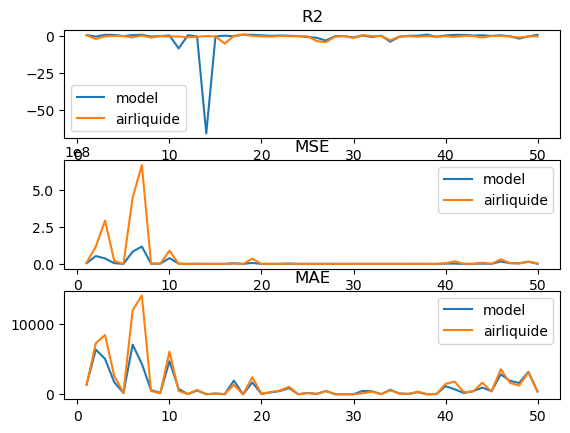

In [7]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

## v2 - on rajoute les données du CAC-40 

In [8]:
# on ajoute les données du CAC aux dataframe global
df_global_with_cac = df_global.copy()
cac = pd.read_csv("../data/^FCHI.csv")
cac["horodate"] = pd.to_datetime(cac["Date"])
cac = cac.drop(["High", "Low", "Date", "Close", "Adj Close", "Volume"], axis = 1)
cac = cac[cac["horodate"] <= pd.to_datetime("2023-01-31")]
df_global_with_cac = pd.merge(df_global_with_cac, cac, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()
df_global_with_cac.rename({"Open": "CAC"}, axis = 1, inplace = True)

In [9]:
# on sépare à nouveau en client 
clients_CAC = group_by_clients(df_global_with_cac)

In [10]:
# on peut alors créer les données de test : 
X_train_CAC, X_test_CAC, y_train_CAC, y_test_CAC, test_data_CAC = make_train_test_set(clients_CAC, ["jour", "forecasted_consumption", "CAC"], ["real_consumption"])

In [11]:
# création des modèles : 
models_CAC = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_CAC): 
    model.fit(X_train_CAC[i], y_train_CAC[i])

In [12]:
y_pred_CAC = []
for i, model in enumerate(models_CAC) : 
    y_pred_CAC.append(model.predict(X_test_CAC[i]).reshape(len(X_test_CAC[i])))

### Evaluation des modèles

In [14]:
evaluation_model_CAC = []
for i in range(n): 
    evaluation_model_CAC.append(metrics(test_data_CAC[i]["real_consumption"], y_pred_CAC[i]))

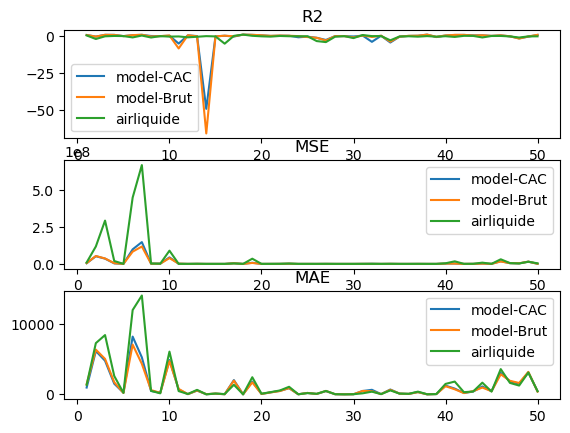

In [19]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_CAC], label = "model-CAC")
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model-Brut")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()